In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import stats
import glob as glob
import math
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

## This notebook checks the distributions of the bootstrapped graph metric data to determine what statisitcal tests should be used

In [18]:
gm_3q = pd.read_csv('/home/mlauber/jad2024/data_paths_and_cleaning/data/final_cleaned_quartiles/graph_metrics_adni_a4_bootstrapped_3quant.csv')
print(gm_3q['Centiloid Quantile'].unique())

[0 1 2]


I. subdivide adni and a4 from gm3q df 


In [19]:
adni_gm = gm_3q[gm_3q['Dataset']=='ADNI']
a4_gm = gm_3q[gm_3q['Dataset']=='A4']
print(adni_gm['Dataset'].nunique())
print(a4_gm['Dataset'].nunique())

1
1


II. Visualize the distributions of the graph metrics to determine what statistical tests are apprporiate 
* Weighted clustering coefficient 
* Weighted average path length
* Weighted small world coefficient 

In [20]:
def combined_plot(df, metric):
    dataset_name = df['Dataset'].iloc[0]
    quartile_groups = df.groupby('Centiloid Quantile')
    n_quartiles = len(quartile_groups)
    
    fig, axes = plt.subplots(n_quartiles, 2, figsize=(15, 6 * n_quartiles))
    
    if n_quartiles == 1:
        axes = [axes]
    
    axes = axes.flatten()
    
    # Metric-specific settings
    metric_settings = {
        'Weighted Clustering Coefficient': {'color': 'skyblue', 'label': 'Weighted Clustering Coefficient'},
        'Weighted Avg. Shortest Path Length': {'color': 'm', 'label': 'Weighted Avg. Shortest Path Length'},
        'Weighted Small World': {'color': 'blue', 'label': 'Weighted Small World'}
    }
    
    color = metric_settings[metric]['color']
    label = metric_settings[metric]['label']
    
    for (quartile, group_df), (ax1, ax2) in zip(quartile_groups, zip(axes[::2], axes[1::2])):
        # Add 1 to the quartile label
        quartile += 1
        sns.histplot(group_df[metric], kde=True, color=color, ax=ax1)
        ax1.set_title(f'Distribution of {label} in Quartile {quartile} of {dataset_name}')
        ax1.set_xlabel(label)
        ax1.set_ylabel('Frequency')
        ax1.grid(True)
        
        stats.probplot(group_df[metric], dist="norm", plot=ax2)
        ax2.set_title(f'Q-Q Plot of {label} in Quantile {quartile} of {dataset_name}')
        ax2.set_xlabel('Theoretical Quantiles')
        ax2.set_ylabel('Ordered Values')
        ax2.grid(True)
    
    plt.tight_layout()

    directory = "dis_plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    safe_dataset_name = dataset_name.replace(' ', '_').replace('.', '_').replace('/', '_')
    
    filename = f"{directory}/{safe_dataset_name}_{label.replace(' ', '_')}.png"
    return fig
    
    plt.show()

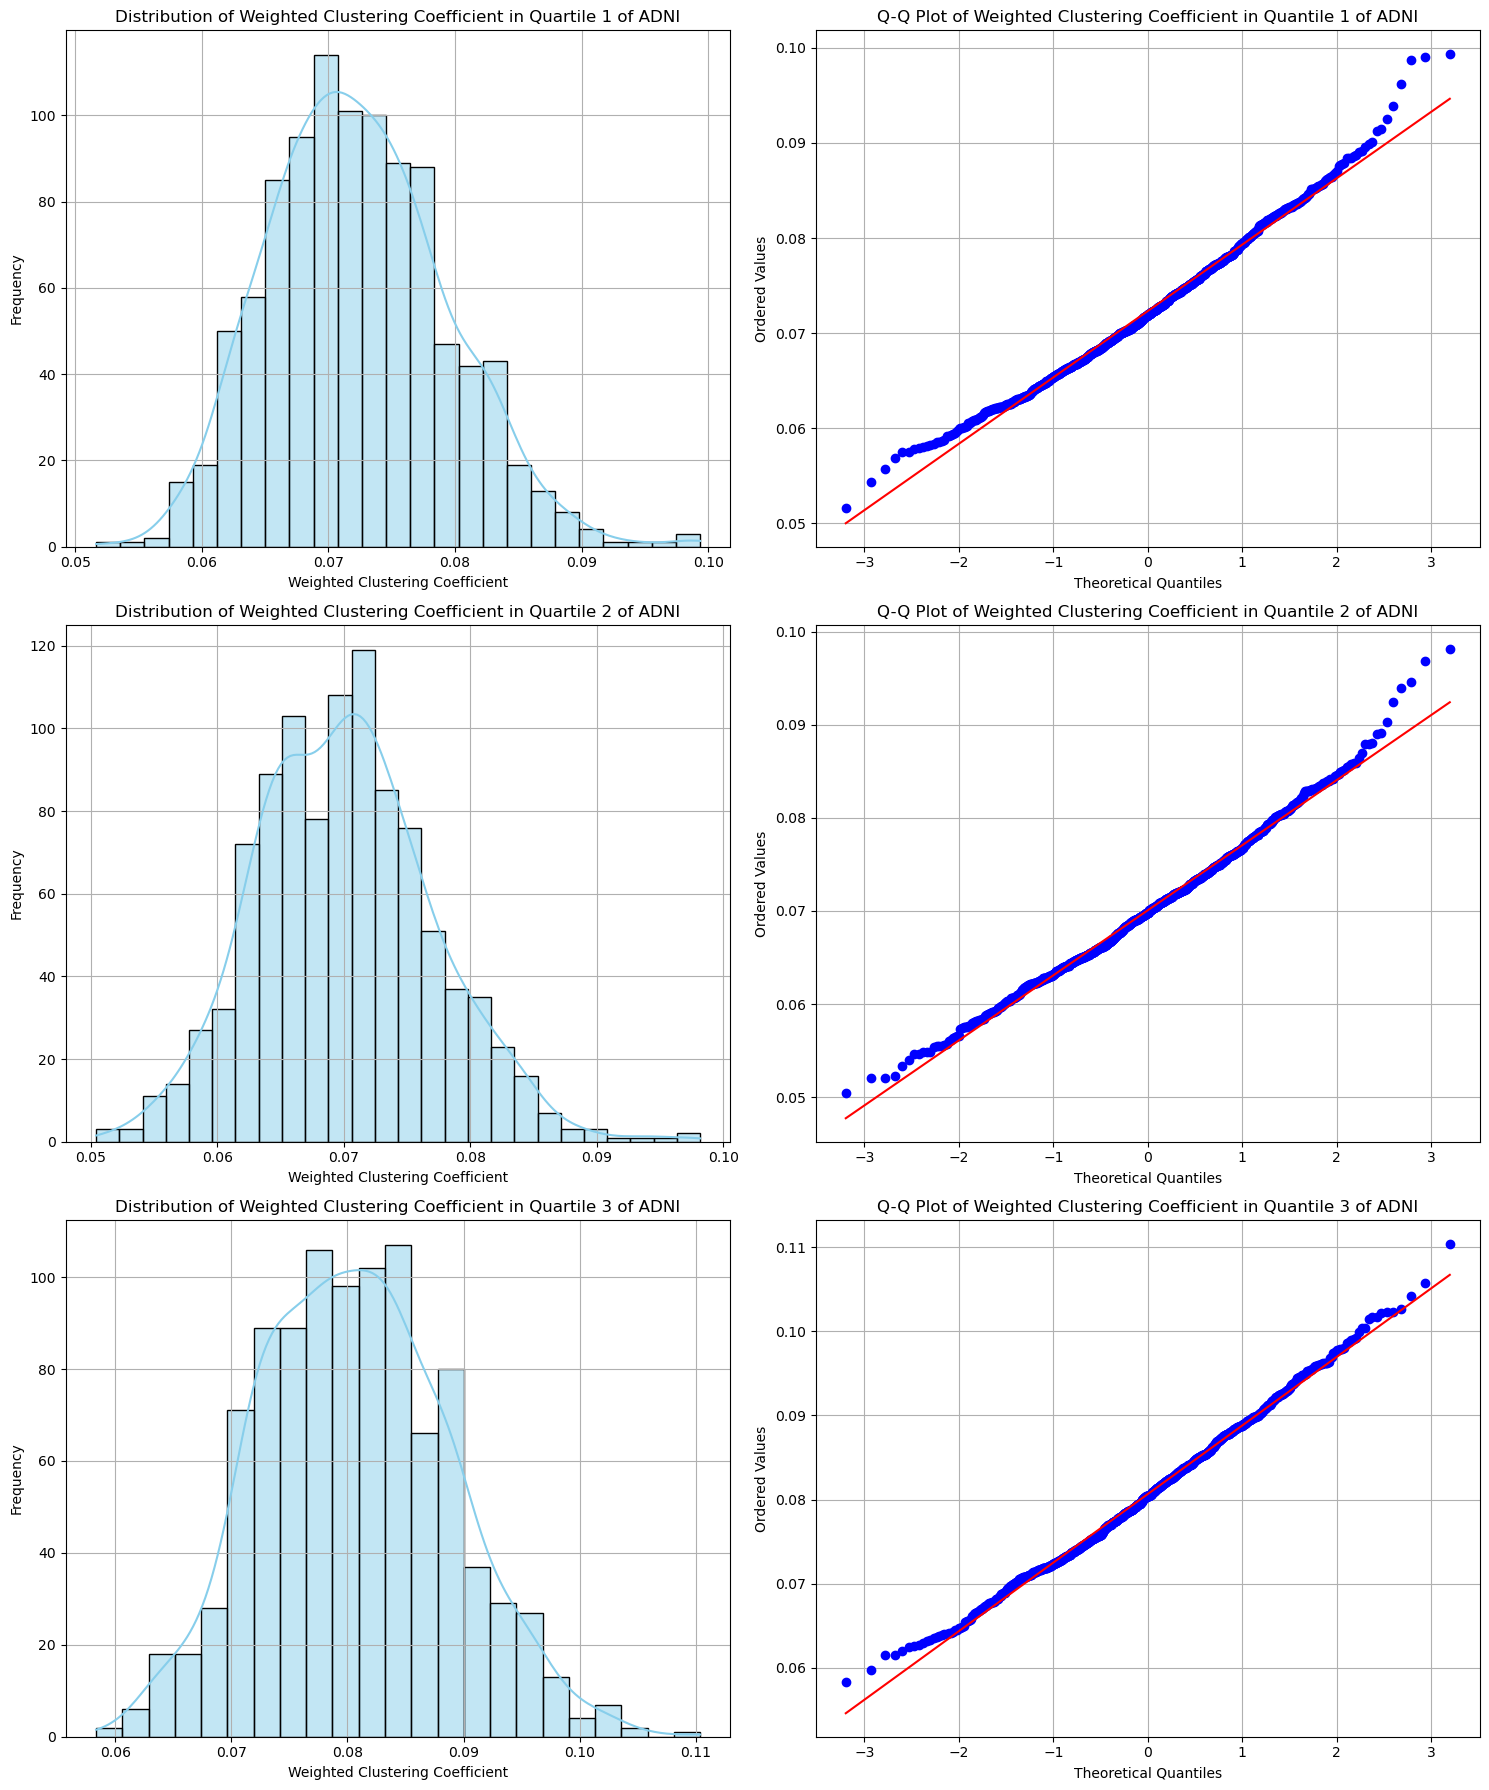

In [21]:
#call if for adni_gm
adni_gm_cc_plot = combined_plot(adni_gm, 'Weighted Clustering Coefficient')
# plt.show()

adni_gm_cc_plot.savefig('/home/mlauber/jad2024/analyze_graphs/figures/dis_plots/new_adni_cc_metric_dis.pdf', dpi=300, format='pdf')

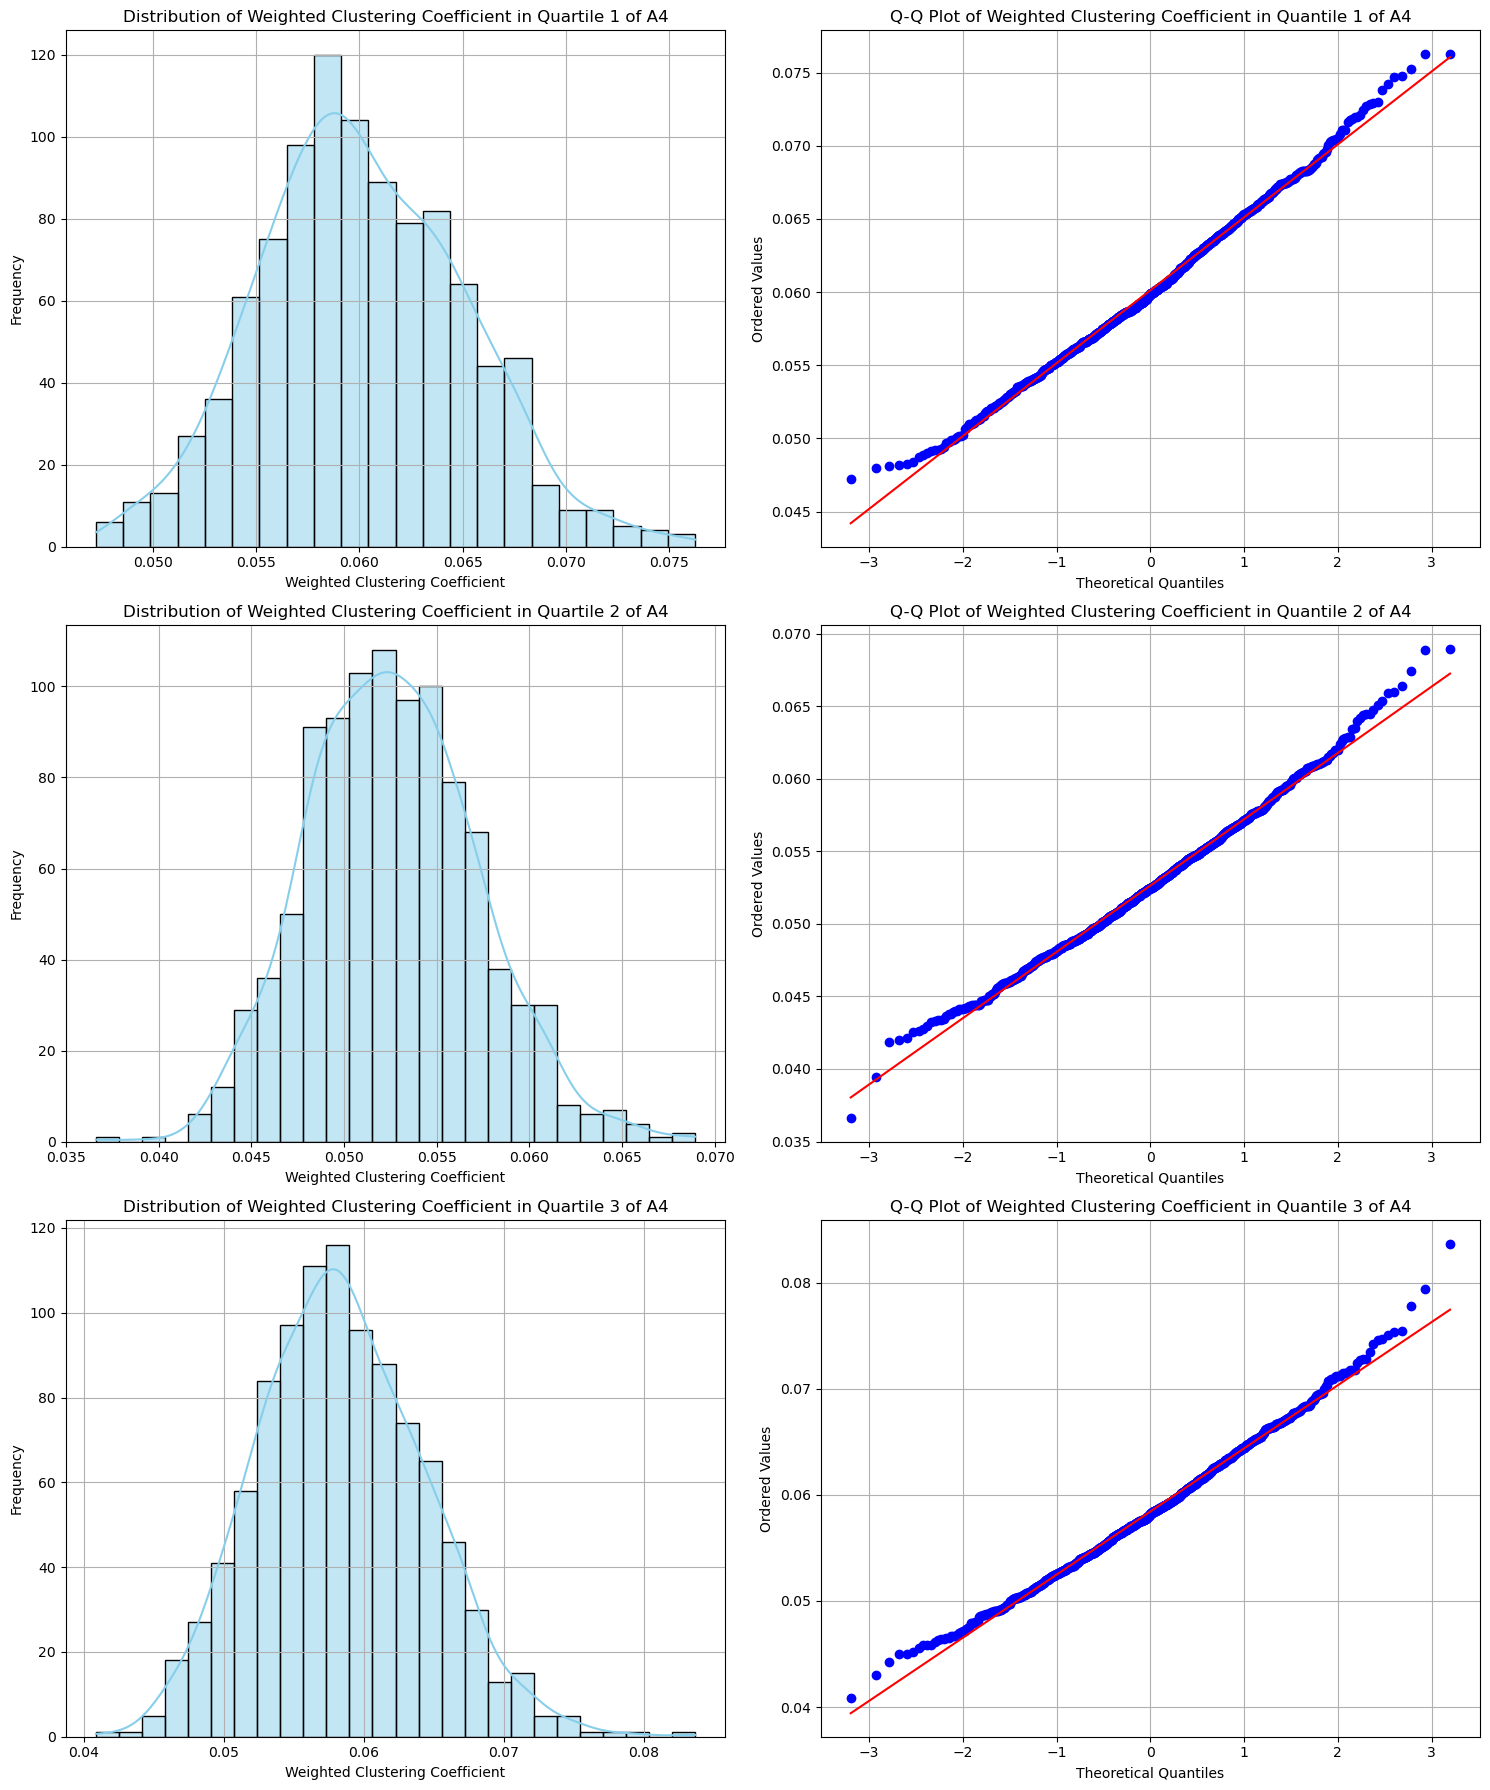

In [22]:
combined_plot(a4_gm, 'Weighted Clustering Coefficient')
plt.savefig('/home/mlauber/jad2024/analyze_graphs/figures/dis_plots/new_a4_cc_metric_dis.pdf', dpi=300, format='pdf')

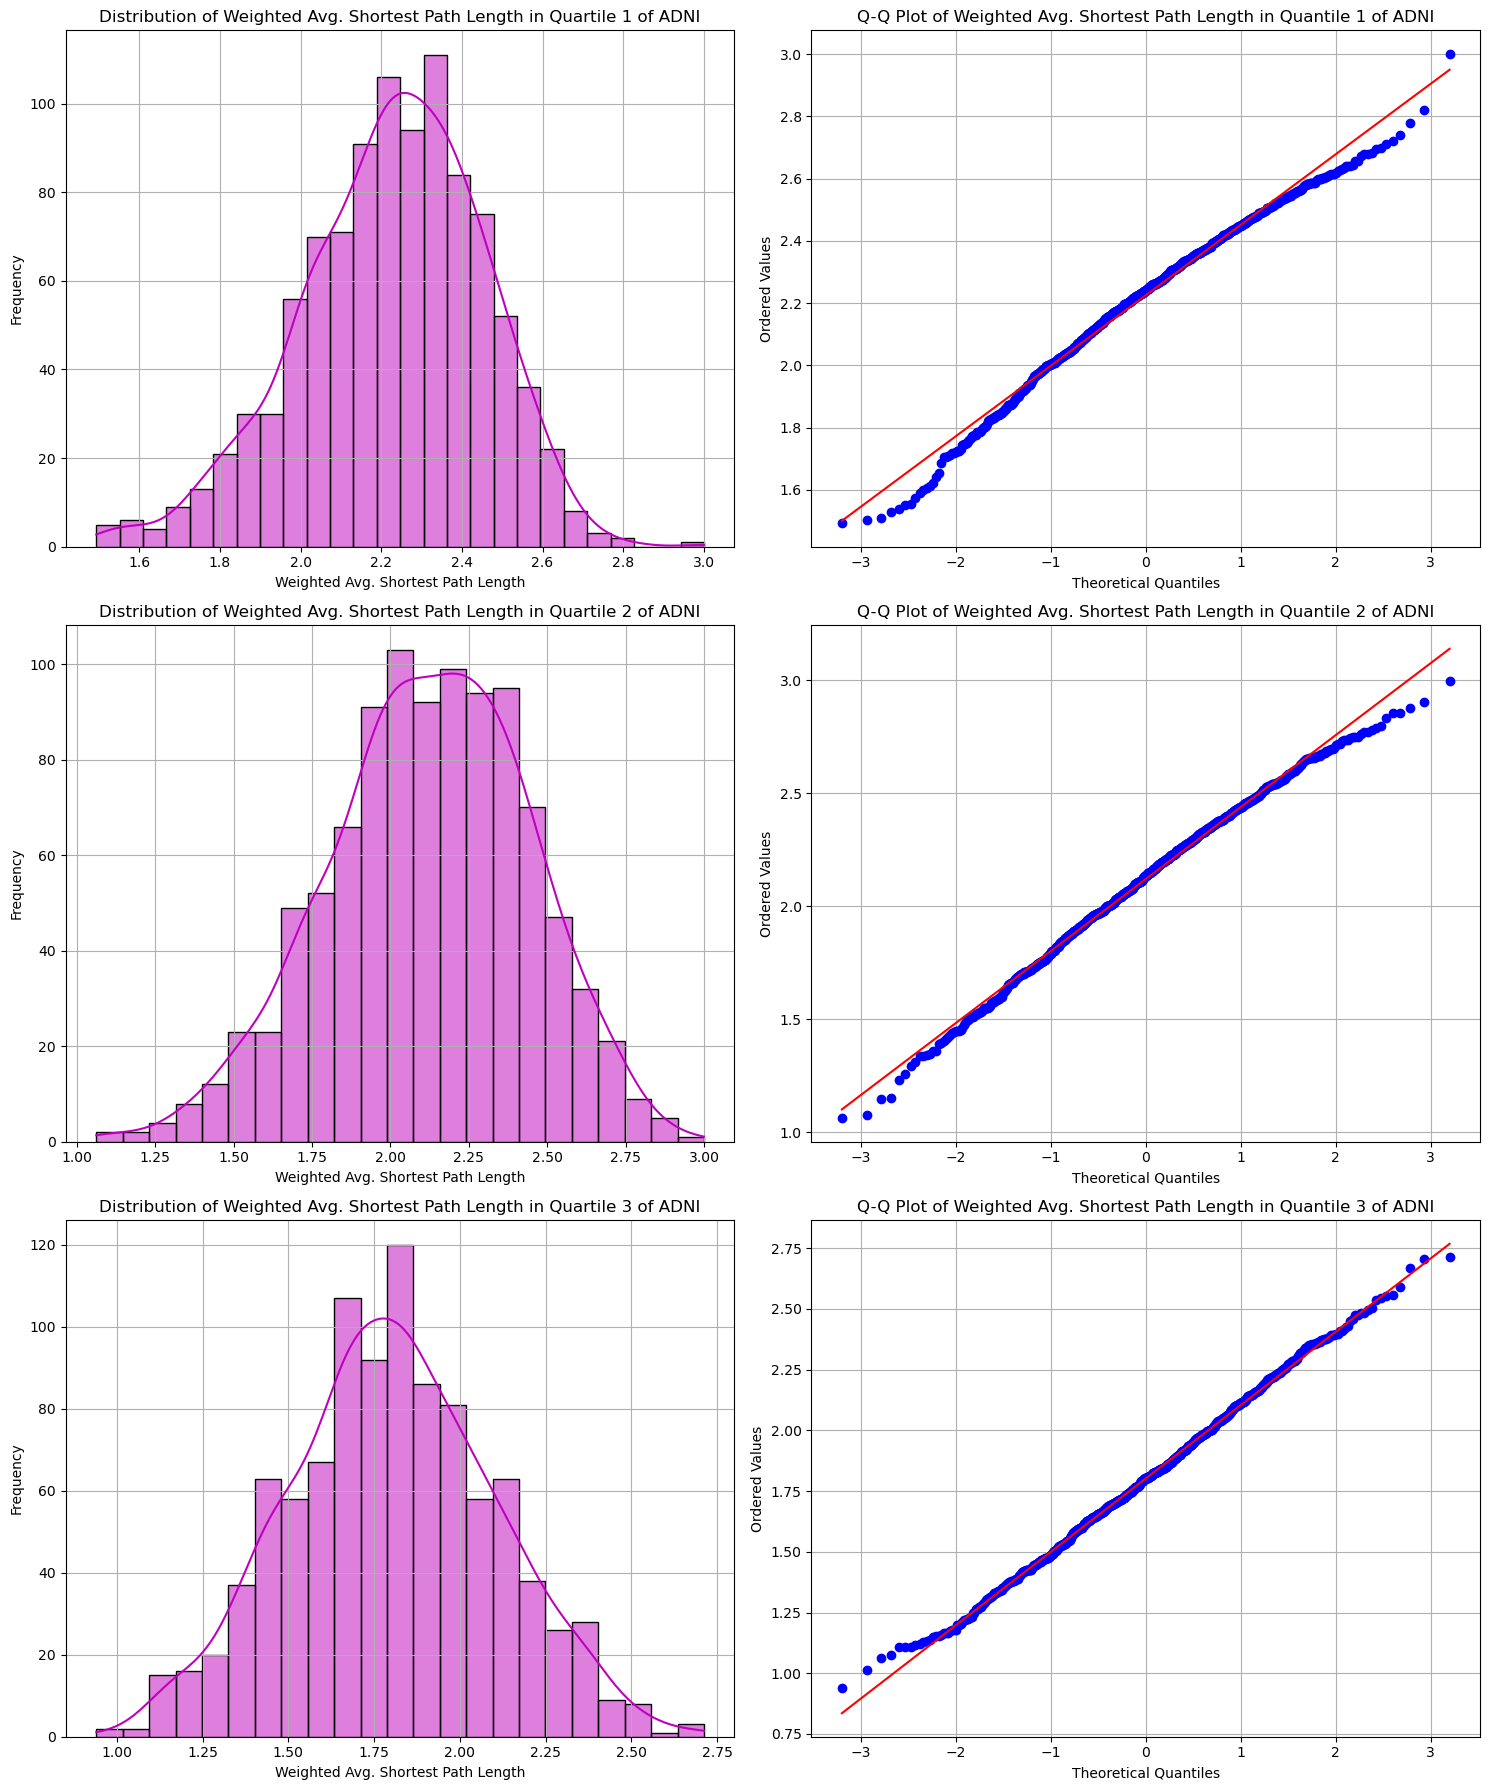

In [23]:
combined_plot(adni_gm, 'Weighted Avg. Shortest Path Length')
plt.savefig('/home/mlauber/jad2024/analyze_graphs/figures/dis_plots/new_adni_spl_metric_dis.pdf', dpi=300, format='pdf')

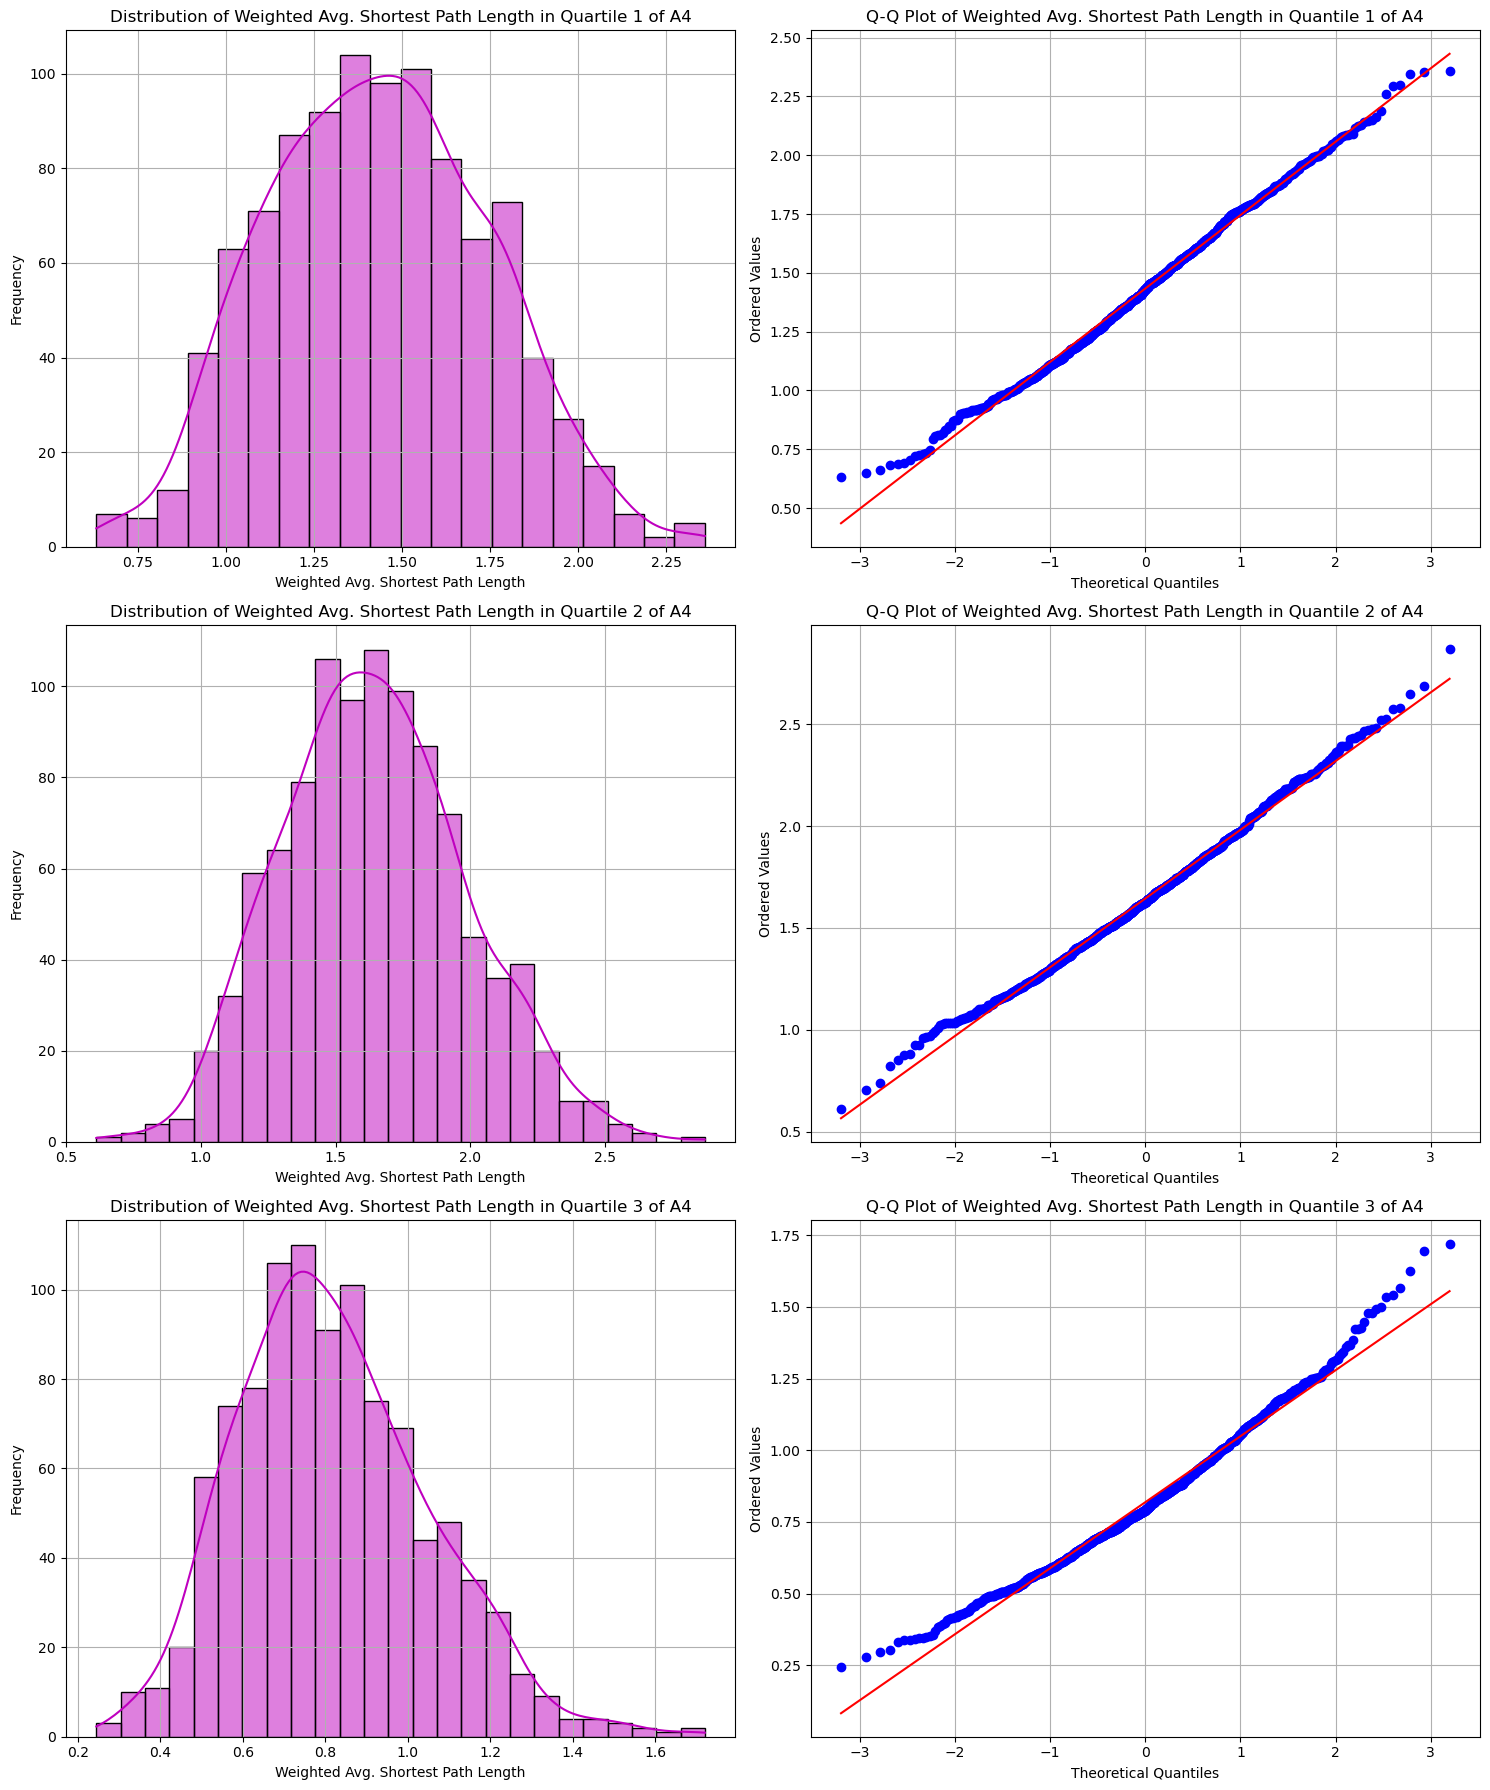

In [24]:
combined_plot(a4_gm, 'Weighted Avg. Shortest Path Length')
plt.savefig('/home/mlauber/jad2024/analyze_graphs/figures/dis_plots/new_a4_spl_metric_dis.pdf', dpi=300, format='pdf')

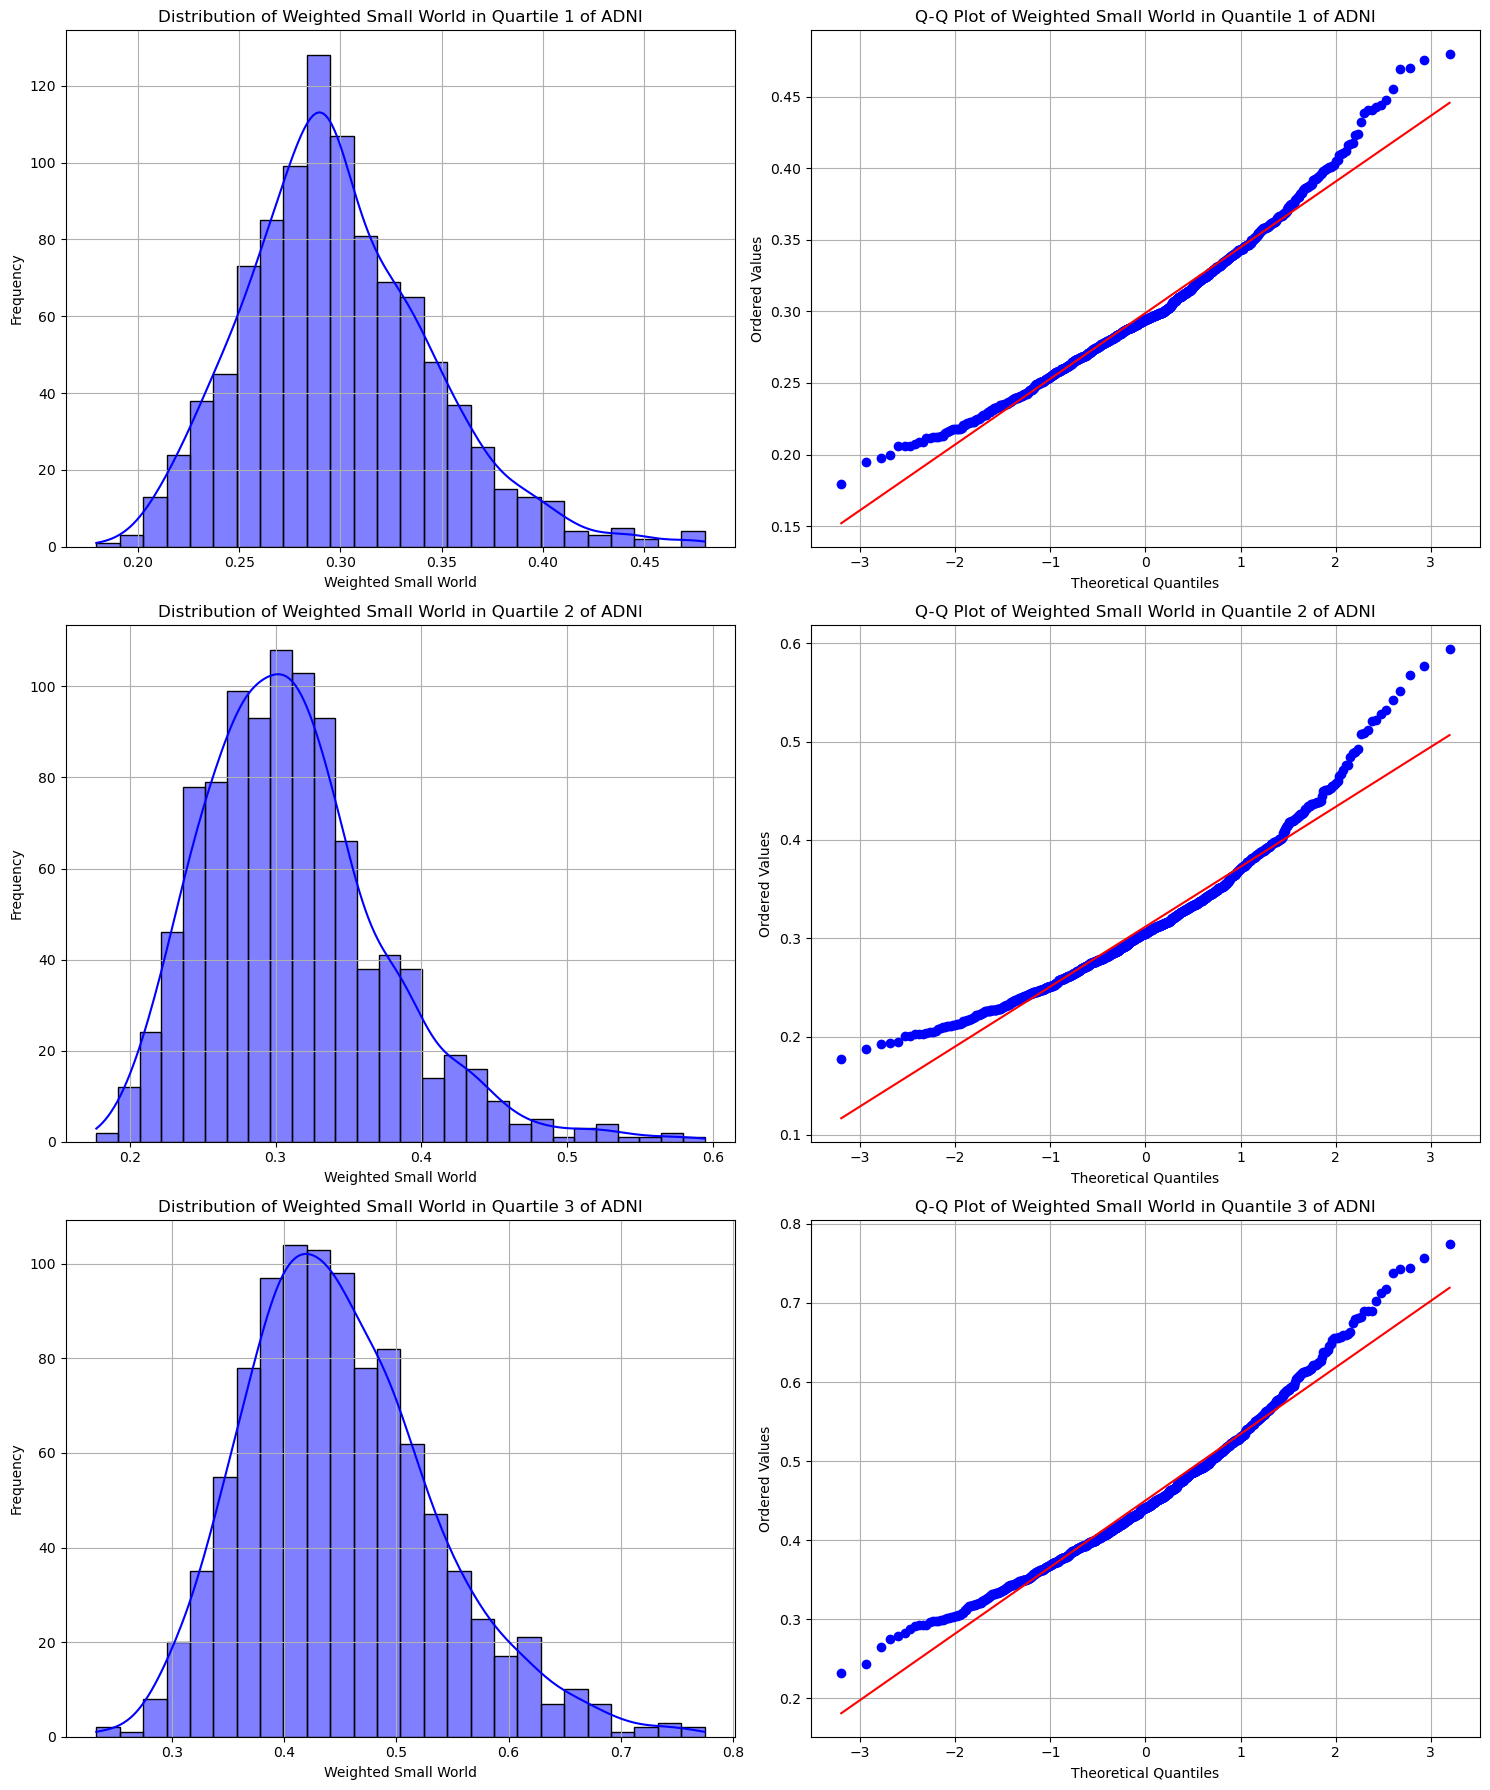

In [25]:
combined_plot(adni_gm, 'Weighted Small World')
plt.savefig('/home/mlauber/jad2024/analyze_graphs/figures/dis_plots/new_adni_sm_metric_dis.pdf', dpi=300, format='pdf')

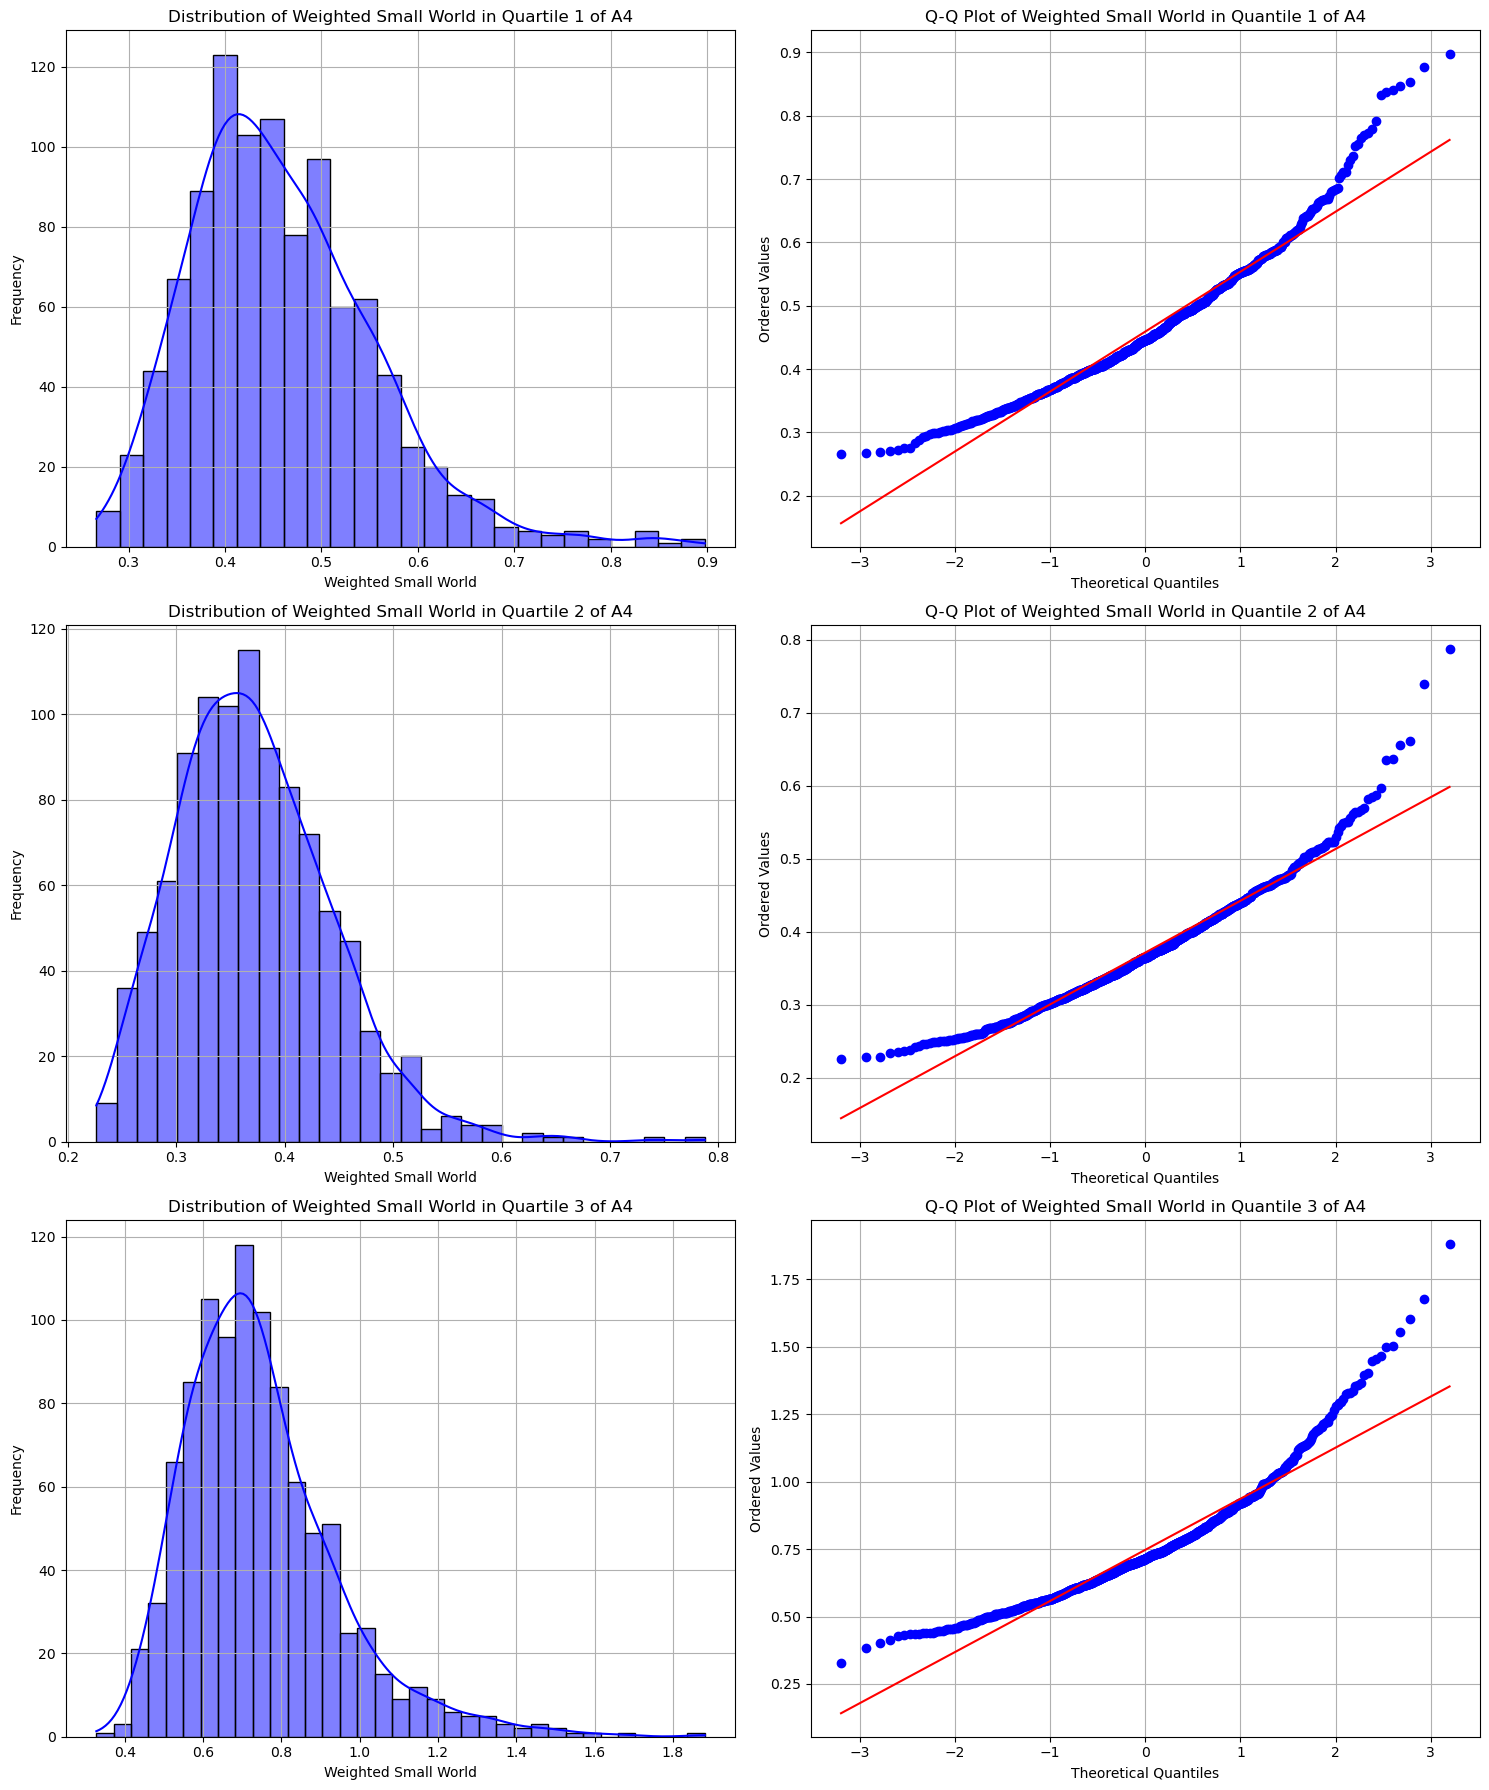

In [26]:
combined_plot(a4_gm, 'Weighted Small World')
plt.savefig('/home/mlauber/jad2024/analyze_graphs/figures/dis_plots/new_a4_sm_metric_dis.pdf', dpi=300, format='pdf')

## Summary: 
* Clustering coefficient and path length are reasonably Gaussian, proceed with ANOVA
* Small world coefficient: Curvature at both ends (kurtosis) indicates a deviation from the normality assumption
* Use a non parametric statistical test like Kruskall-Wallis 